# Hyperparameter Optimization Framework인 Optuna 구현 소개

출처: [https://medium.com/optuna/an-introduction-to-the-implementation-of-optuna-a-hyperparameter-optimization-framework-33995d9ec354](https://medium.com/optuna/an-introduction-to-the-implementation-of-optuna-a-hyperparameter-optimization-framework-33995d9ec354)

# An Introduction to the Implementation of Optuna, a Hyperparameter Optimization Framework

Hyperparameter 최적화는 machine learning 모델이 고성능을 제공하기 위한 가장 중요한 프로세스 중 하나입니다. Optuna는 hyperparameter 최적화를 위한 인기 있는 Python 라이브러리이며 다양한 최적화 알고리즘을 지원하는 사용하기 쉽고 잘 설계된 소프트웨어입니다. 이 아티클에서는 소프트웨어 측면에 중점을 두고, Optuna의 내부 구현에 대해 설명합니다.

Optuna의 내부 구현을 이해하려면 주요 구성 요소의 역할과 전체 실행 flow를 알아야 합니다. 그러나 Optuna가 활발히 개발되고 코드 양이 늘어남에 따라 코드 읽기에서 전체 흐름을 파악하기가 어려워졌습니다. 그래서 Minituna라는 작은 프로그램을 만들었습니다. Minituna에는 각각 100, 200, 300줄의 코드가 있는 세 가지 버전이 있습니다. 최종 버전은 약 300줄에 불과한 작은 프로그램이지만 실용적인 pruning algorithm을 사용하면 꽤 Optuna와 비슷합니다.

> Minituna: optuna의 내부 디자인 이해를 위한  a toy hyperparameter optimization framework ([https://github.com/CyberAgentAILab/minituna](https://github.com/CyberAgentAILab/minituna))

전체 코드를 입력하여 Minituna 코드를 읽는 연습을 하는 것이 좋습니다. Minituna가 어떻게 설계되었는지 잘 이해하고 나면 Optuna 코드를 읽는 것이 그리 어렵지 않을 것입니다. 이 아티클에서는 Minituna 코드에서 쉽게 읽을 수 있는 간단한 사실을 다루지 않습니다. 대신 Minituna 코드를 읽고 연습하는 데 도움이 되는 몇 가지 팁과 Minituna와 Optuna의 차이점을 설명하려고 합니다.

# minituna_v1: The Roles of Trial, Study, Sampler, and Storage and How They Are Called
Minituna v1은 약 100줄의 아주 작은 프로그램입니다. 하지만, 그 안에는 이미 주요 components가 구현되어 있고 다음과 같은 프로그램을 실행할 수 있습니다. 이 아티클에 제시된 모든 예제는 Optuna와 호환되며 import 문을 ```import optuna as minituna```로 교체해도 문제 없이 실행됩니다.

In [2]:
import optuna as minituna
 
def objective(trial: minituna.Trial) -> float:
    x = trial.suggest_uniform("x", 0, 10)
    y = trial.suggest_uniform("y", 0, 10)
    return (x - 3) ** 2 + (y - 5) ** 2
 
if __name__ == "__main__":
    study = minituna.create_study()
    study.optimize(objective, 10)
    print("Best trial:", study.best_trial)

[I 2022-10-12 16:01:12,781] A new study created in memory with name: no-name-e6d7b09d-9ca6-461d-9621-5044e49265fc
[I 2022-10-12 16:01:12,783] Trial 0 finished with value: 6.383340153968535 and parameters: {'x': 5.526322070483465, 'y': 4.967798289538049}. Best is trial 0 with value: 6.383340153968535.
[I 2022-10-12 16:01:12,784] Trial 1 finished with value: 21.646696942057417 and parameters: {'x': 7.412071176564664, 'y': 3.523407681523192}. Best is trial 0 with value: 6.383340153968535.
[I 2022-10-12 16:01:12,785] Trial 2 finished with value: 17.54418199355505 and parameters: {'x': 6.976970642115358, 'y': 3.685509031865335}. Best is trial 0 with value: 6.383340153968535.
[I 2022-10-12 16:01:12,786] Trial 3 finished with value: 50.73517605790817 and parameters: {'x': 9.168186951089707, 'y': 8.562112546553637}. Best is trial 0 with value: 6.383340153968535.
[I 2022-10-12 16:01:12,787] Trial 4 finished with value: 53.62053573537184 and parameters: {'x': 8.607625205086828, 'y': 0.2909581341

Best trial: FrozenTrial(number=0, values=[6.383340153968535], datetime_start=datetime.datetime(2022, 10, 12, 16, 1, 12, 782947), datetime_complete=datetime.datetime(2022, 10, 12, 16, 1, 12, 782947), params={'x': 5.526322070483465, 'y': 4.967798289538049}, distributions={'x': FloatDistribution(high=10.0, log=False, low=0.0, step=None), 'y': FloatDistribution(high=10.0, log=False, low=0.0, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


이것이 Optuna에서 objective function을 정의하는 방법입니다. objective function은 trail object를 가져와 objective value를 return합니다. 이 예에서 objective function은 10번 호출되고, 10번의 시행에서 얻은 최고의 값과 parameter가 print됩니다.

이제 minituna_v1 코드를 읽어봅시다. minituna_v1에는 5개의 클래스가 정의되어 있으며, 이러한 주요 component는 Optuna 코드에서도 자주 나타납니다. 각 클래스가 무엇을 하고 어떻게 호출되는지 코드를 살펴봅시다.

- **Study: 주어진 optimization task에 대한 정보를 관리하는 component**

주어진 최적화 task에 대해 ,```study``` component는 사용할 알고리즘(Sampler) 및 ```trial``` results를 저장할 위치(Storage)와 같은 모든 정보를 관리합니다. 이들은 function```.create_study()```에서 argument로 지정됩니다.

<br/>

- **Trial: 각각의 trial에 해당하는 component**

objective function은 ```trial``` object에서 제공하는 API를 통해 Optuna에서 parameters를 샘플링하고, 중간 값을 보고하여 pruning을 수행합니다.

<br/>

- **Storage: optimization trials의 결과를 저장하는 component**

이 component 덕분에 Optuna는 RDB storages를 지원할 수 있어, ```trial``` results의 지속성과 분산 최적화가 가능합니다.

<br/>

- **FrozenTrial: storage layer에 대한 각 trial의 representation**

이 component는 각 trial에서 objective function을 평가하는 데 사용되는 objective value와 parameter를 저장합니다. 예를 들어, RDB storages를 사용할 때, SQL에 의해 DB에서 검색된 정보는 ```FrozenTrial``` object에 넣습니다.

<br/>

- **Sampler: 평가할 다음 parameter를 선택하기 위한 알고리즘을 구현하는 component**

이 component는 더 나은 objective value를 얻기 위해 평가되어야 하는 parameter를 찾는 알고리즘을 구현합니다. Bayesian optimization 또는 evolution strategies를사용한 hyperparameter sampling은 ```sampler``` component에서 정의됩니다. 설명의 편의를 위해 Minituna에서 random sampling만 구현했습니다. 이 아티클에서는 Optuna에서 지원하는 Bayesian optimization 및 evolution strategies에 대한 세부 정보를 다루지 않습니다.

# minituna_v2: How to Use Categorical, Integer, and LogUniform
minituna_v2는 ```suggest_uniform()``` 외에 다음의 API를 제공합니다.

- ```suggest_categorical(name, choices=[...])```: categorical parameters 샘플링


- ```suggest_int(name, low, high)```: integer parameters 샘플링


- ```suggest_loguniform(name, low, high)```:  로그 스케일 공간에서 실제 parameters를 샘플링

<br/>

이를 통해 다음과 같이 objective function을 최적화할 수 있습니다.

In [3]:
def objective(trial):
    iris = sklearn.datasets.load_iris()
    x, y = iris.data, iris.target
 
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_loguniform("svc_c", 1e-10, 1e10)
        classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto")
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=10
        )
 
    score = sklearn.model_selection.cross_val_score(
        classifier_obj, x, y, n_jobs=-1, cv=3
    )
    accuracy = score.mean()
    return 1 - accuracy # Changing to a minimization problem.

minituna_v2 코드를 이해하는 핵심은 모든 parameter가 storage 내부에서 float으로 표시된다는 것입니다. 앞의 예에서 categorical parameters는 "SVC" 및 "RandomForest"와 같은 string이지만, 이들조차도 float으로 표시됩니다. 이를 위해 다음과 같은 abstract base class를 소개합니다.

In [5]:
class BaseDistribution(abc.ABC):
    @abc.abstractmethod
    def to_internal_repr(self, external_repr: Any) -> float:
        ...
 
    @abc.abstractmethod
    def to_external_repr(self, internal_repr: float) -> Any:
        ...

각 parameter에는 ```internal_repr```와 ```external_repr```의 두 가지 표현이 있습니다. ```internal_repr```은 storage 내부의 parameter 표현이며, float 값입니다. ```external_repr```은 실제로 objective function에서 사용되는 표현이므로 string, integer 또는 무엇이든 가능합니다.

```
>>> import minituna_v2 as minituna
>>> distribution = minituna.CategoricalDistribution(choices=["SVC", "RandomForest"])
>>> distribution.to_internal_repr("SVC")
0
>>> distribution.to_internal_repr("RandomForest")
1
>>> distribution.to_external_repr(0)
'SVC'
>>> distribution.to_external_repr(1)
'RandomForest'
```

internal_repr과 external_repr 간의 변환을 위해서는 distribution object가 필요합니다. 따라서, distribution object도 sotrage에 저장됩니다. 이것이 FrozenTrial에 distribution 필드가 추가된 이유입니다.

# Understand the Storage Layer Properly
minituna_v2까지 코드를 읽었다면, Optuna 코드 읽기를 시작할 수 있습니다. 다음으로 minituna_v3에 대해 자세히 알아보기 전에 storage layer에 대해 간략히 소개하겠습니다.

Optuna의 소스 코드를 읽기 시작했을 때 가장 먼저 한 일은 storage layer에 대한 이해를 높이는 것이었습니다. storage에 어떤 정보가 있는지 이해하면 Optuna가 각 function을 구현하기 위해 무엇을 해야 하는지 쉽게 상상할 수 있기 때문입니다. 또한, storage layer의 코드를 읽으면 Minituna와 Optuna의 설계 차이점을 대략적으로 파악할 수 있습니다. storage layer를 더 잘 이해하려면 RDBStorage에 대한 [SQLAlchemy 모델 정의](https://github.com/optuna/optuna/blob/v2.0.0/optuna/storages/_rdb/models.py)를 확인하는 것이 좋습니다.

In [7]:
class StudyModel(BaseModel):
    __tablename__ = "studies"
    study_id = Column(Integer, primary_key=True)
    study_name = Column(String(MAX_INDEXED_STRING_LENGTH), ...)
    direction = Column(Enum(StudyDirection), nullable=False)
 
 
class TrialModel(BaseModel):
    __tablename__ = "trials"
    trial_id = Column(Integer, primary_key=True)
    number = Column(Integer)
    study_id = Column(Integer, ForeignKey("studies.study_id"))
    state = Column(Enum(TrialState), nullable=False)
    value = Column(Float)
    datetime_start = Column(DateTime, default=datetime.now)
    datetime_complete = Column(DateTime)
 
 
class TrialParamModel(BaseModel):
    __tablename__ = "trial_params"
    __table_args__ = (UniqueConstraint("trial_id", "param_name"),)
    param_id = Column(Integer, primary_key=True)
    trial_id = Column(Integer, ForeignKey("trials.trial_id"))
    param_name = Column(String(MAX_INDEXED_STRING_LENGTH))
    param_value = Column(Float)
    distribution_json = Column(String(MAX_STRING_LENGTH))

다음은 storage layer에서 코드를 읽을 때 염두에 두어야 할 몇 가지 추가 사항입니다:

- 코드를 단순하게 유지하기 위해, Minituna의 storage는 하나의 study에 대한 정보만 담을 수 있지만, Optuna의 코드는 여러 study를 지원합니다.


- Optuna는 여러 study를 지원하기 때문에 TrialModel의 trial_id 필드가 연구 내에서 항상 점진적으로 증가하는 것은 아닙니다. 그래서 Optuna에 number 필드를 추가한 이유는 알고리즘을 구현하기 위해 study 내에서 1, 2, 3 등과 같이 단순히 올라가는 identifier를 갖는 것이 유용하기 때문입니다.


- TrialState에는 PRUNED 및 WAITING의 두 가지 state가 있습니다. 전자는 나중에 minituna_v3 섹션에서 설명할 pruning function을 구현하기 위해 추가되었고, 후자는 function ```.enqueue_trial()``` 구현을 위해 추가되었습니다.

# minituna_v3: Pruning by Median Stopping Rule
minituna_v3은 약 300줄의 프로그램이고, pruning (early stopping)을 지원합니다. pruning은 모든 Optuna 사용자가 사용하는 feature가 아니므로 관심이 없으면 이해하지 않아도 됩니다.

In [ ]:
def objective(trial):
    clf = MLPClassifier(
        hidden_layer_sizes=tuple(
            [trial.suggest_int("n_units_l{}".format(i), 32, 64)
         	for i in range(3)]
        ),
        learning_rate_init=trial.suggest_loguniform("lr_init", 1e-5, 1e-1),
    )
 
    for step in range(100):
        clf.partial_fit(x_train, y_train, classes=classes)
        accuracy = clf.score(x_valid, y_valid)
        error = 1 - accuracy
 
        # Report intermediate values.
        trial.report(error, step)
 
        # Throw a TrialPruned exception if the state requires early termination.
        if trial.should_prune():
            raise minituna.TrialPruned()
    return error

pruning function을 사용하기 위해 두가지 API가 필요합니다.

1. ```trial.report(value, step)```: storage에서 중간 값을 저장

2. ```trial.should_prune()```이 true하면, ```TrialPruned()```가 작동하고 learning process를 stop

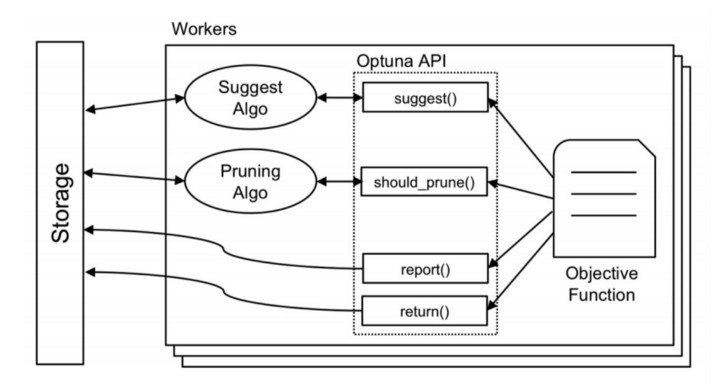

이 API에서 알 수 있듯이 현재 Optuna에서 지원하는 모든 pruning 알고리즘은 중간 값을 기준으로 prune 여부를 결정합니다. Minituna에서는 Median Stopping Rule이라는 알고리즘을 구현했습니다. 다행히 Optuna에서 지원하는 pruning 알고리즘은 그렇게 복잡하지 않습니다.

이러한 모든 알고리즘은 중간 값이 낮으면 시간을 절약하기 위해 최종 값도 그렇게 좋지 않을 것이라는 경험적 지식을 기반으로 학습 프로세스를 조기에 종료할 수 있습니다. 아래에서 설명할 median stopping rule 외에도 Optuna는 Successive Halving 및 Hyperband와 같은 알고리즘도 지원하지만 기본 아이디어는 대체로 동일합니다.

Median stopping rule은 기본적으로 각 단계에서 아래쪽 절반(이전 trial의 intermediate values의 median value보다 나쁜 것)을 잘라냅니다. 다음 figure는 median stopping rule이 작동하는 방식을 보여줍니다. 코드가 간단하기 때문에 다음 그림과 함께 읽으면 median stopping rule이 어떻게 작동하는지 잘 알 수 있습니다.

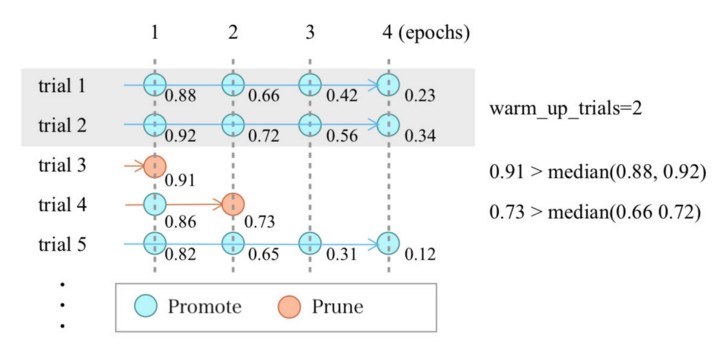

Optuna의 SuccessiveHalving 및 Hyperband 구현을 읽고 싶다면 염두에 두어야 할 한 가지 사항이 있습니다. Optuna는 특정 trial을 일시 중단하거나 재개하도록 설계되지 않았기 때문에 알고리즘이 약간 수정되었으며 논문에 설명된 알고리즘과 다르게 작동합니다. Optuna의 Successive Halving 구현에 대해 자세히 알아보려면 Optuna의 논문에서 Algorithm 1을 읽으세요. Hyperband의 경우 Hyperband를 구현한 crcrpar이 게시한 블로그 아티클 [How We Implement Hyperband in Optuna](https://medium.com/optuna/optuna-supports-hyperband-93b0cae1a137)를 읽어보시길 바랍니다.

또한, 여기서는 Pruner의 디자인과 관련된 문제를 다룰 것입니다. Minituna의 소스 코드에서 볼 수 있듯이 Optuna에서는 Pruner와 Sampler 인터페이스가 명확하게 분리되어 있습니다. 이렇게 하면 Optuna의 코드가 명확해지며 Sampler와 Pruner 간에 쉽게 전환 가능하고 어떤 조합으로든 사용할 수 있습니다.

반면에 일부 알고리즘은 Pruner와 Sampler가 함께 작동해야 하므로 현재 디자인에서는 구현할 수 없습니다. 사실, Pruner와 Sampler가 함께 작동하도록 하고, Hyperband를 구현하기 위해 백그라운드에서 약간의 트릭이 사용되었습니다. Pruner와 Sampler의 인터페이스에 대해서는 아직 논의의 여지가 있습니다.

# How Joint Sampling Works in the Define-by-Run Interface
또한 구현의 제한된 size로 인해 Minituna에서 다루지 않은 Joint Sampling에 대해서도 설명합니다. 이 메커니즘은 Define-by-Run 인터페이스를 사용하는 Optuna에 특별합니다. parameter 간의 종속성을 고려한 ```SkoptSampler```(GP-BO) 및 ```CmaEsSampler```와 같은 최적화 알고리즘을 구현하려면 Joint Sampling의 개념을 이해해야 합니다. Bayesian optimization 또는 evolution strategies에 대한 연구를 수행하는 경우, Joint Sampling에 익숙해지면 Optuna에서 고유한 Sampler를 구현할 수 있어야 합니다.

Minituna의 Sampler 인터페이스 디자인은 Optuna의 v0.12.0 때와 거의 동일합니다. 그러나 Optuna v0.13.0 이상 버전의 인터페이스는 다릅니다. 다음 Sampler 인터페이스를 비교하면 차이점을 알 수 있습니다.

- v0.12.0: optuna/samplers/[base.py](https://github.com/optuna/optuna/blob/v0.12.0/optuna/samplers/base.py)

- v2.0.0: optuna/samplers/[\_base.py](https://github.com/optuna/optuna/blob/v2.0.0/optuna/samplers/_base.py)

Joint Sampling을 더 잘 이해하기 위해 몇 가지 예를 살펴보고 각 objective function에 대한 search space가 어떻게 보이는지 살펴보겠습니다.

In [ ]:
def objective(trial):
    x = trial.suggest_uniform("x", -100, 100)
    y = trial.suggest_categorical("y", [-1, 0, 1])
    return x ** 2 + y

이 objective function의 search space는 항상 아래와 같을 것입니다.

In [ ]:
{
    'x': UniformDistribution(low=-100, high=100),
    'y': CategoricalDistribution(choices=[-1, 0, 1])
}

자, 그럼 다음 objective function의 search space은 어떨까요?

In [ ]:
def objective(trial):
    x, y = ...
 
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = sklearn.svm.SVC(...")
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(...)
 
    accuracy = ...
    return accuracy

Define-by-Run 인터페이스에서 search space는 런타임 때 결정됩니다. 이 예제에는 search space에 if 문이 있기 때문에 둘 이상의 search space가 있습니다.

In [ ]:
# SVC
{
  'classifier': CategoricalDistribution(choices=["SVC", "RandomForest"]),
  'svc_c': LogUniformDistribution(low=1e-10, high=1e10),
}

In [ ]:
# RandomForest
{
  'classifier': CategoricalDistribution(choices=["SVC", "RandomForest"]),
  'rf_max_depth': IntUniformDistribution(low=2, high=32),
}

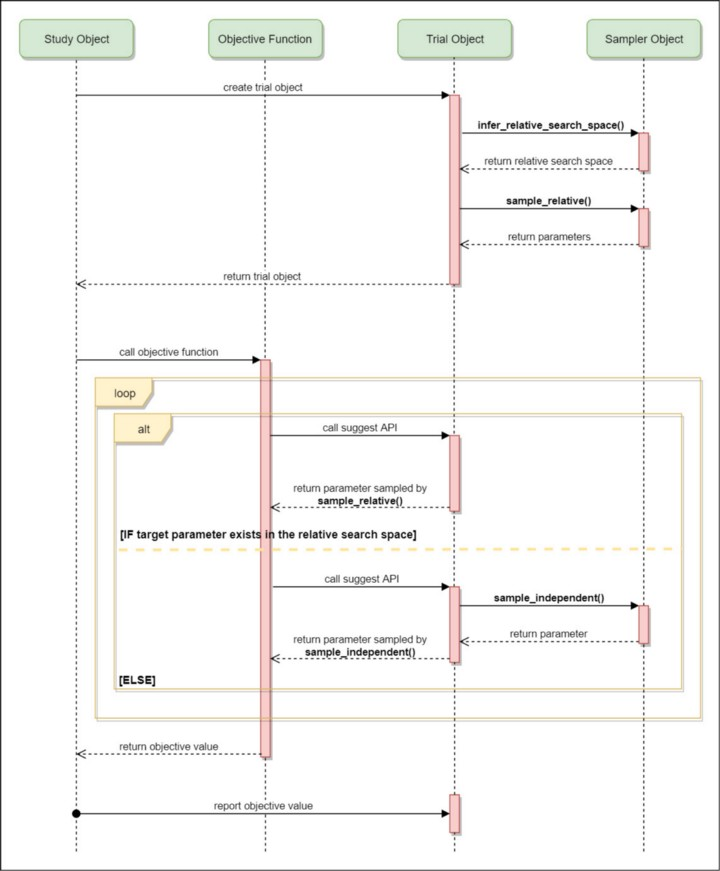

그런 다음 ```CmaEsSampler```와 ```SkoptSampler```는 ```Sampler.infer_relative_search_space(study, trial)``` method를 사용하여 모든 search spaces에 나타나는 항목을 추출하고 ```Sampler.sample_relative(study, trial, search_space)```에 세 번째 argument로 전달합니다. 즉, 위의 예에서는 classifier parameter만 joint search space로 취급됩니다. GP-BO 및 CMA-ES는 Joint Samping이라고 하는 이 joint search space의 샘플에만 사용됩니다. 위의 그림은 Joint Sampling이 작동하는 방식에 대한 다이어그램입니다.

joint search space에 포함되지 않은 ```svc_c```, ```rf_max_depth``` 및 다른 parameters는 ```RandomSampler```, ```TPESampler```와 같은 variable 간의 종속성을 고려하지 않는 Sampler로 돌아갑니다.

# Summary
이 아티클에서는 Minituna를 소개하고 Minituna 및 Optuna 코드를 읽는 방법에 대한 몇 가지 추가 팁을 제공했습니다. Minituna v2까지 모든 코드를 입력하여 Minituna 코드를 읽는 연습을 했고, 전체 프로세스를 잘 이해했다면 Optuna 코드를 읽을 수 있을 것입니다. 가장 관심 있는 component부터 시작하는 것이 좋습니다. 또한, Optuna 개발 팀은 매우 지원적이고 상세한 PR 리뷰를 제공합니다. 이 아티클이 향후 Optuna 개발에 참여하는 데 도움이 되기를 바랍니다.